In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# load the topography data
down_reach = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/downreach_longprofile.csv')
up_reach = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/upreach_longprofile.csv')

# load the groundwater data
SM21_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SM21.csv')
SM22_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SM22.csv')
SM23_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SM23.csv')
SP22_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SP22.csv')
SP23_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SP23.csv')

wells = pd.DataFrame({ #the order for these is GW1 to GW9
    'Distance': [3.1, 8.5, 17, 29.5, 0, 18, 17.2, 36.2, 36.9],
    'Elevation': [2722.372, 2722.683, 2723.117, 2724.179, 2733.515, 2734.527, 2734.794, 2736.657, 2736.795]  
})
piezometers = pd.DataFrame({ #the order for these is P1 to P6 (sll stilling wells)
    'Distance': [0, 20.7, 34.5, 2.6, 35.8, 46.5],
    'Elevation': [2722.052, 2723.399, 2724.514, 2733.302, 2736.42, 2737.485]
})
temprobes = pd.DataFrame({ #the order is TP1 thru TP8
    'Distance': [13, 23, 41, 50, 10.15, 14.6, 31.4, 56.6],
    'Elevation': [2722.652, 2723.389, 2724.88, 2725.338, 2733.665, 2733.998, 2735.669, 2738.474]  
})

### Groundwater Elevations Interpolations 

The idea behind this is to linearly interpolate the groundwater levels spatially, so if we have a time series of groundwater wells in one point in space, we will need to work with a multi-index pandas dataframe

In [22]:
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM21_GW.iloc[:, 0]),
    'gw1_level': SM21_GW.iloc[:, 1],
    'gw3_level': SM21_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)
print(gw_data)

                       gw1_level    gw3_level  gw1_distance  gw3_distance
time                                                                     
2021-07-29 12:15:00  2721.454020  2722.335332           3.1          17.0
2021-07-29 12:30:00  2721.454223  2722.333197           3.1          17.0
2021-07-29 12:45:00  2721.454223  2722.333199           3.1          17.0
2021-07-29 13:00:00  2721.454223  2722.333201           3.1          17.0
2021-07-29 13:15:00  2721.454027  2722.333007           3.1          17.0
...                          ...          ...           ...           ...
2021-09-22 22:45:00  2721.324188  2722.147975           3.1          17.0
2021-09-22 23:00:00  2721.324378  2722.148165           3.1          17.0
2021-09-22 23:15:00  2721.324378  2722.145255           3.1          17.0
2021-09-22 23:30:00  2721.324961  2722.145838           3.1          17.0
2021-09-22 23:45:00  2721.324377  2722.147005           3.1          17.0

[5327 rows x 4 columns]


In [3]:
index = pd.MultiIndex.from_product([gw_data.index, down_reach.iloc[:, 0]], names=['time', 'distance'])
print(index)

MultiIndex([('2021-07-29 12:15:00',  0.0),
            ('2021-07-29 12:15:00',  0.3),
            ('2021-07-29 12:15:00',  1.0),
            ('2021-07-29 12:15:00',  1.5),
            ('2021-07-29 12:15:00',  2.0),
            ('2021-07-29 12:15:00',  2.5),
            ('2021-07-29 12:15:00',  3.1),
            ('2021-07-29 12:15:00',  3.5),
            ('2021-07-29 12:15:00',  4.1),
            ('2021-07-29 12:15:00',  4.5),
            ...
            ('2021-09-22 23:45:00', 37.5),
            ('2021-09-22 23:45:00', 38.0),
            ('2021-09-22 23:45:00', 38.5),
            ('2021-09-22 23:45:00', 39.0),
            ('2021-09-22 23:45:00', 39.5),
            ('2021-09-22 23:45:00', 39.7),
            ('2021-09-22 23:45:00', 40.0),
            ('2021-09-22 23:45:00', 40.5),
            ('2021-09-22 23:45:00', 41.0),
            ('2021-09-22 23:45:00', 41.5)],
           names=['time', 'distance'], length=479430)


In [23]:
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM21_GW.iloc[:, 0]),
    'gw1_level': SM21_GW.iloc[:, 1],
    'gw3_level': SM21_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, down_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw1_level_at_time = gw_data.loc[time, 'gw1_level']
    gw3_level_at_time = gw_data.loc[time, 'gw3_level']
    gw1_distance_at_time = gw_data.loc[time, 'gw1_distance'] # these are always the same actually 
    gw3_distance_at_time = gw_data.loc[time, 'gw3_distance']
    
    if np.isnan(gw1_level_at_time) or np.isnan(gw3_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw1_distance_at_time, gw3_distance_at_time], [gw1_level_at_time, gw3_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

# print the DataFrame without NaN values
print(df.dropna())

                                 gw_level
time                distance             
2021-07-29 12:15:00 0.0       2721.257468
                    0.3       2721.276490
                    1.0       2721.320872
                    1.5       2721.352574
                    2.0       2721.384276
...                                   ...
2021-09-22 23:45:00 39.7      2723.490433
                    40.0      2723.508188
                    40.5      2723.537779
                    41.0      2723.567370
                    41.5      2723.596961

[418950 rows x 1 columns]


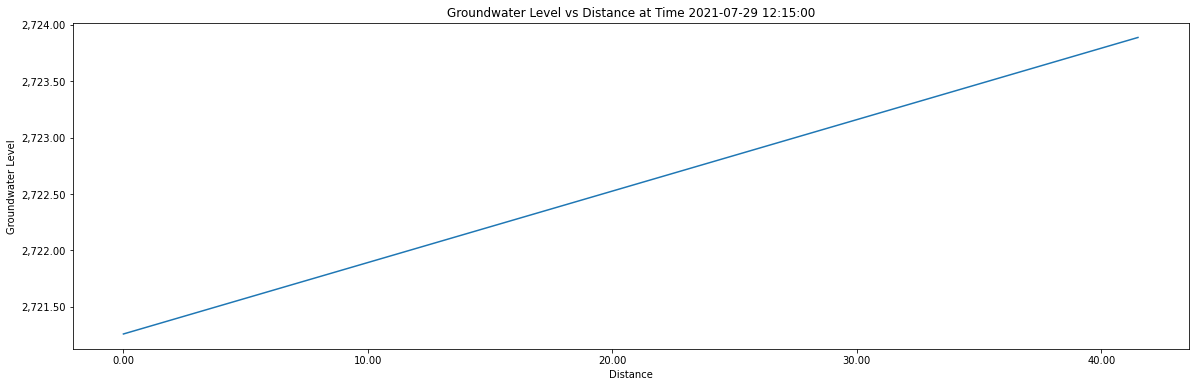

In [24]:
# Select a specific time point
time_point = gw_data.index[0]

# Slice the DataFrame for the specific time point
df_time_slice = df.loc[(time_point, slice(None))]

# Get the distances from the index
distances = df_time_slice.index.get_level_values('distance')

# Plot the groundwater level against distance
plt.figure(figsize=(20, 6))
plt.plot(distances, df_time_slice['gw_level'])
plt.xlabel('Distance')
plt.ylabel('Groundwater Level')
plt.title(f'Groundwater Level vs Distance at Time {time_point}')

# Change the format of the x-axis and y-axis labels
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

plt.show()

In [103]:
# The time series data for the two wells
times = pd.to_datetime(SM21_GW.iloc[:, 0])
gw1_levels = SM21_GW.iloc[:, 1]
gw3_levels = SM21_GW.iloc[:, 2]

distances = down_reach.iloc[:, 0] # distances along the river where you want to interpolate
gw1_distance = wells.iloc[0, 0] # distance of GW1 on the river
gw3_distance = wells.iloc[2, 0] # distance of GW3 on the river

# Create a MultiIndex with the product of the times and distances
index = pd.MultiIndex.from_product([times, distances], names=['time', 'distance'])

# Create a DataFrame with the MultiIndex
df = pd.DataFrame(index=index)

# Now you can interpolate the groundwater levels for each well and each point in space and time
for time in times:
    if time in gw1_levels.index and time in gw3_levels.index:
        gw1_level_at_time = gw1_levels.loc[time]
        gw3_level_at_time = gw3_levels.loc[time]
        df.loc[time, 'gw_level'] = np.interp(distances, [gw1_distance, gw3_distance], [gw1_level_at_time, gw3_level_at_time])
    else:
        df.loc[time, 'gw_level'] = np.nan

print(df.dropna())

Empty DataFrame
Columns: [gw_level]
Index: []


Downstream Right Bank

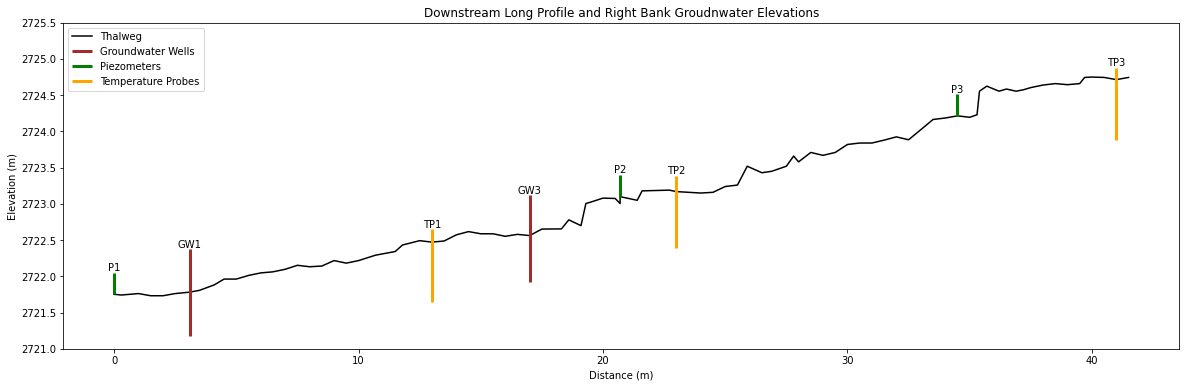

In [95]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(down_reach.iloc[:, 0], down_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW1
plt.vlines(wells.iloc[0,0], wells.iloc[0,1]-1.20, wells.iloc[0,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[0,0], wells.iloc[0,1], 'GW1', ha='center', va='bottom')
# GW3
plt.vlines(wells.iloc[2,0], wells.iloc[2,1]-1.20, wells.iloc[2,1], colors='brown', linewidth=3)
plt.text(wells.iloc[2,0], wells.iloc[2,1], 'GW3', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P1
plt.vlines(piezometers.iloc[0,0], piezometers.iloc[0,1]-0.3, piezometers.iloc[0,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[0,0], piezometers.iloc[0,1], 'P1', ha='center', va='bottom')
# P2
plt.vlines(piezometers.iloc[1,0], piezometers.iloc[1,1]-0.3, piezometers.iloc[1,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[1,0], piezometers.iloc[1,1], 'P2', ha='center', va='bottom')
# P3
plt.vlines(piezometers.iloc[2,0], piezometers.iloc[2,1]-0.3, piezometers.iloc[2,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[2,0], piezometers.iloc[2,1], 'P3', ha='center', va='bottom')

# add in temperature probes
# TP1
plt.vlines(temprobes.iloc[0,0], temprobes.iloc[0,1]-1, temprobes.iloc[0,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[0,0], temprobes.iloc[0,1], 'TP1', ha='center', va='bottom')
# TP2
plt.vlines(temprobes.iloc[1,0], temprobes.iloc[1,1]-1, temprobes.iloc[1,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[1,0], temprobes.iloc[1,1], 'TP2', ha='center', va='bottom')
# TP3
plt.vlines(temprobes.iloc[2,0], temprobes.iloc[2,1]-1, temprobes.iloc[2,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[2,0], temprobes.iloc[2,1], 'TP3', ha='center', va='bottom')

# Set the limits of the y-axis
ax.set_ylim(2721, 2725.5)

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Downstream Long Profile and Right Bank Groudnwater Elevations')
ax.legend()

# Show the plot
plt.show()

Downstream Left Bank

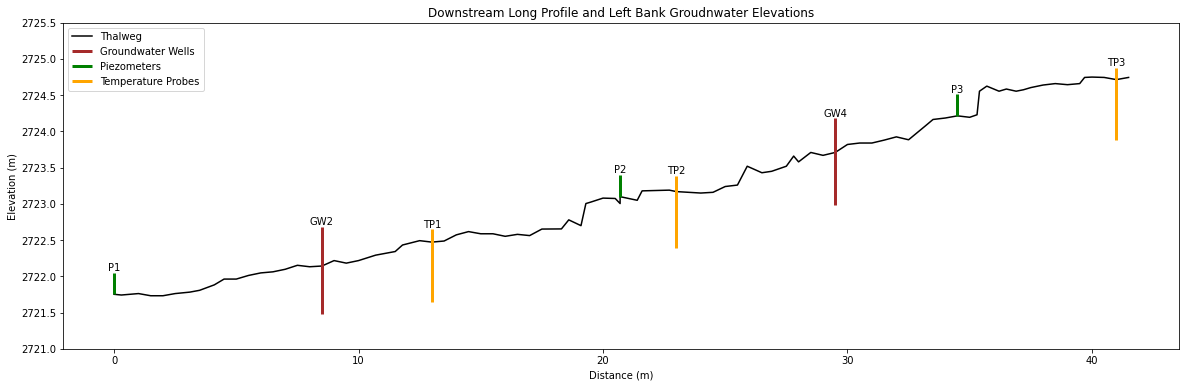

In [96]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(down_reach.iloc[:, 0], down_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW2
plt.vlines(wells.iloc[1,0], wells.iloc[1,1]-1.20, wells.iloc[1,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[1,0], wells.iloc[1,1], 'GW2', ha='center', va='bottom')
# GW4
plt.vlines(wells.iloc[3,0], wells.iloc[3,1]-1.20, wells.iloc[3,1], colors='brown', linewidth=3)
plt.text(wells.iloc[3,0], wells.iloc[3,1], 'GW4', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P1
plt.vlines(piezometers.iloc[0,0], piezometers.iloc[0,1]-0.3, piezometers.iloc[0,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[0,0], piezometers.iloc[0,1], 'P1', ha='center', va='bottom')
# P2
plt.vlines(piezometers.iloc[1,0], piezometers.iloc[1,1]-0.3, piezometers.iloc[1,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[1,0], piezometers.iloc[1,1], 'P2', ha='center', va='bottom')
# P3
plt.vlines(piezometers.iloc[2,0], piezometers.iloc[2,1]-0.3, piezometers.iloc[2,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[2,0], piezometers.iloc[2,1], 'P3', ha='center', va='bottom')

# add in temperature probes
# TP1
plt.vlines(temprobes.iloc[0,0], temprobes.iloc[0,1]-1, temprobes.iloc[0,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[0,0], temprobes.iloc[0,1], 'TP1', ha='center', va='bottom')
# TP2
plt.vlines(temprobes.iloc[1,0], temprobes.iloc[1,1]-1, temprobes.iloc[1,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[1,0], temprobes.iloc[1,1], 'TP2', ha='center', va='bottom')
# TP3
plt.vlines(temprobes.iloc[2,0], temprobes.iloc[2,1]-1, temprobes.iloc[2,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[2,0], temprobes.iloc[2,1], 'TP3', ha='center', va='bottom')

# Set the limits of the y-axis
ax.set_ylim(2721, 2725.5)

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Downstream Long Profile and Left Bank Groudnwater Elevations')
ax.legend()

# Show the plot
plt.show()

Upstream Right Bank

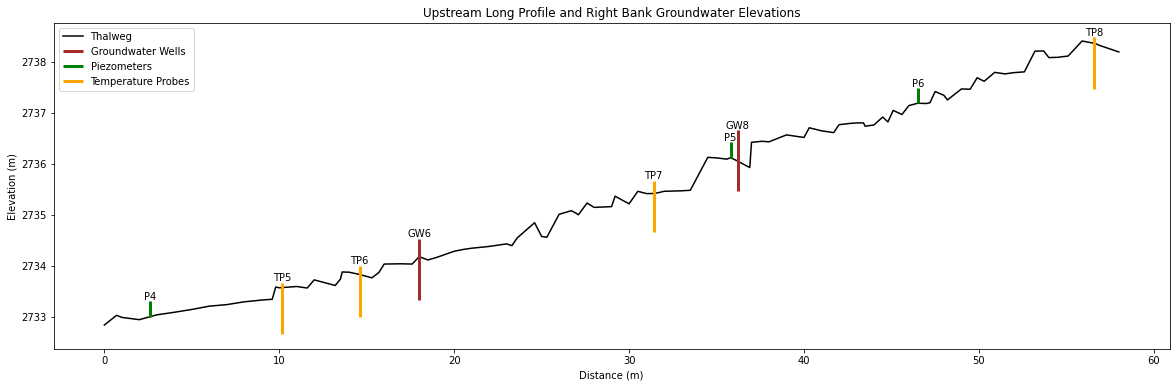

In [97]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(up_reach.iloc[:, 0], up_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW6
plt.vlines(wells.iloc[5,0], wells.iloc[5,1]-1.20, wells.iloc[5,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[5,0], wells.iloc[5,1], 'GW6', ha='center', va='bottom')
# GW8
plt.vlines(wells.iloc[7,0], wells.iloc[7,1]-1.20, wells.iloc[7,1], colors='brown', linewidth=3)
plt.text(wells.iloc[7,0], wells.iloc[7,1], 'GW8', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P4
plt.vlines(piezometers.iloc[3,0], piezometers.iloc[3,1]-0.3, piezometers.iloc[3,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[3,0], piezometers.iloc[3,1], 'P4', ha='center', va='bottom')
# P5
plt.vlines(piezometers.iloc[4,0], piezometers.iloc[4,1]-0.3, piezometers.iloc[4,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[4,0], piezometers.iloc[4,1], 'P5', ha='center', va='bottom')
# P6
plt.vlines(piezometers.iloc[5,0], piezometers.iloc[5,1]-0.3, piezometers.iloc[5,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[5,0], piezometers.iloc[5,1], 'P6', ha='center', va='bottom')

# add in temperature probes
# TP5
plt.vlines(temprobes.iloc[4,0], temprobes.iloc[4,1]-1, temprobes.iloc[4,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[4,0], temprobes.iloc[4,1], 'TP5', ha='center', va='bottom')
# TP6
plt.vlines(temprobes.iloc[5,0], temprobes.iloc[5,1]-1, temprobes.iloc[5,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[5,0], temprobes.iloc[5,1], 'TP6', ha='center', va='bottom')
# TP7
plt.vlines(temprobes.iloc[6,0], temprobes.iloc[6,1]-1, temprobes.iloc[6,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[6,0], temprobes.iloc[6,1], 'TP7', ha='center', va='bottom')
# TP8
plt.vlines(temprobes.iloc[7,0], temprobes.iloc[7,1]-1, temprobes.iloc[7,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[7,0], temprobes.iloc[7,1], 'TP8', ha='center', va='bottom')

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Upstream Long Profile and Right Bank Groundwater Elevations')
ax.legend()

# Show the plot
plt.show()

Upstream Left Bank

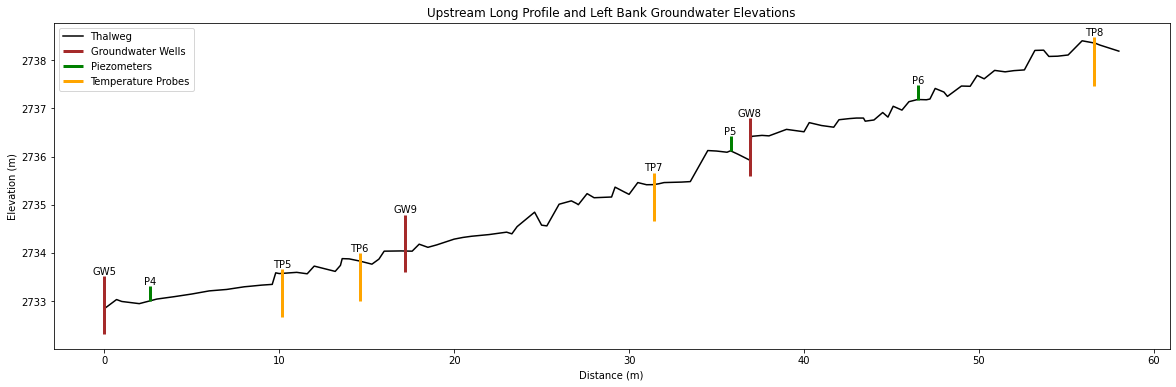

In [98]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(up_reach.iloc[:, 0], up_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW5
plt.vlines(wells.iloc[4,0], wells.iloc[4,1]-1.20, wells.iloc[4,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[4,0], wells.iloc[4,1], 'GW5', ha='center', va='bottom')
# GW7
plt.vlines(wells.iloc[6,0], wells.iloc[6,1]-1.20, wells.iloc[6,1], colors='brown', linewidth=3)
plt.text(wells.iloc[6,0], wells.iloc[6,1], 'GW9', ha='center', va='bottom')
# GW9
plt.vlines(wells.iloc[8,0], wells.iloc[8,1]-1.20, wells.iloc[8,1], colors='brown', linewidth=3)
plt.text(wells.iloc[8,0], wells.iloc[8,1], 'GW8', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P4
plt.vlines(piezometers.iloc[3,0], piezometers.iloc[3,1]-0.3, piezometers.iloc[3,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[3,0], piezometers.iloc[3,1], 'P4', ha='center', va='bottom')
# P5
plt.vlines(piezometers.iloc[4,0], piezometers.iloc[4,1]-0.3, piezometers.iloc[4,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[4,0], piezometers.iloc[4,1], 'P5', ha='center', va='bottom')
# P6
plt.vlines(piezometers.iloc[5,0], piezometers.iloc[5,1]-0.3, piezometers.iloc[5,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[5,0], piezometers.iloc[5,1], 'P6', ha='center', va='bottom')

# add in temperature probes
# TP5
plt.vlines(temprobes.iloc[4,0], temprobes.iloc[4,1]-1, temprobes.iloc[4,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[4,0], temprobes.iloc[4,1], 'TP5', ha='center', va='bottom')
# TP6
plt.vlines(temprobes.iloc[5,0], temprobes.iloc[5,1]-1, temprobes.iloc[5,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[5,0], temprobes.iloc[5,1], 'TP6', ha='center', va='bottom')
# TP7
plt.vlines(temprobes.iloc[6,0], temprobes.iloc[6,1]-1, temprobes.iloc[6,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[6,0], temprobes.iloc[6,1], 'TP7', ha='center', va='bottom')
# TP8
plt.vlines(temprobes.iloc[7,0], temprobes.iloc[7,1]-1, temprobes.iloc[7,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[7,0], temprobes.iloc[7,1], 'TP8', ha='center', va='bottom')

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Upstream Long Profile and Left Bank Groundwater Elevations')
ax.legend()

# Show the plot
plt.show()